# Option pricing with Monte Carlo methods and Geometric Brownian Motion


The main purpose of this notebook is to explore more about Monte Carlo Methods for pricing options, where we assume the underlying follows Geometric Brownian Motion. 

The motivation behind using this as a starting point is such that we can initially compare some results to Black Scholes, which of course has a famous closed form solution for the price of a European Call option under GBM assumptions. This would provide a good comparison point to the analytical closed form solution.

Within this book we will explore how to price different types of options, when we assume the underlying asset follows GBM, but in future projects I will look into different processes.


So to begin, as started we will start with the most simple example, which would be to compare the MC method to the Black and Scholes Result


For some brief introduction:

The Stochastic process $S_t$ is said to follow Geometric Brownian motion if it follows the SDE below

$$
dS_t = \mu S_t dt +  \sigma S_t dW_t\,.
$$

The solution to this SDE is

$$
S_t = S_0 * exp ((\mu - \sigma^2/2)t + \sigma W_t)))
$$

Let us begin by using Monte Carlo methods to estimate the value of an option under the GBM equations above



We can estimate this directly via the Euler-Maruyama method (i.e. typical Euler method where we calculate the value in discrete steps, where we utilize the derivative multiplied by the distance, but add a 'shock' or the contribution of $\sigma$)

I.e. If we divide the total time horizon $T$ into $N$ steps, can define $\Delta t T/N$

We can define

$S_{n+1} = S_n + \mu S_n \Delta t + \sigma S_n \epsilon \sqrt{\Delta t} = S_n (1 + \mu\Delta t+ \sigma\epsilon\sqrt{\Delta t})$

where $\epsilon \sim N(0,1)$ '


The function that does this is below

In [10]:
#mu, sigma: mu and sigma from formula
#T = total time to option expiry
#NumInterval = number of intervals in the discretization of T into chunks
#NumTrial = number of trials in the simulation, # of chains
#S0 = starting price of S

import numpy as np
def MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0):
    dt = T/NumInterval
    S_mat = np.zeros((NumInterval + 1, NumTrial))
    
    #init starting value = 100
    S_mat[0] = S0
    
    #standard normal vector, size NumInt
    normalvec = np.random.normal(0,1,(NumInterval,NumTrial))

    #follow formula above
    for t in range(1,NumInterval+1):
        S_mat[t] = normalvec[t-1] * sigma * np.sqrt(dt)
        S_mat[t] += (1 + mu * dt)
        S_mat[t] *= S_mat[t-1]
    return S_mat

We can test the result below, for 100 intervals and 1000 different trial / realizations of the simulation

In [11]:
mu = 0.05
sigma = 0.4
T = 1
NumInterval = 1000
NumTrial = 1000
S0 = 100
S = MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0)

We can see from the plot below what each trial looks like (for first 10 realizations), it visually appears to follow the GBM

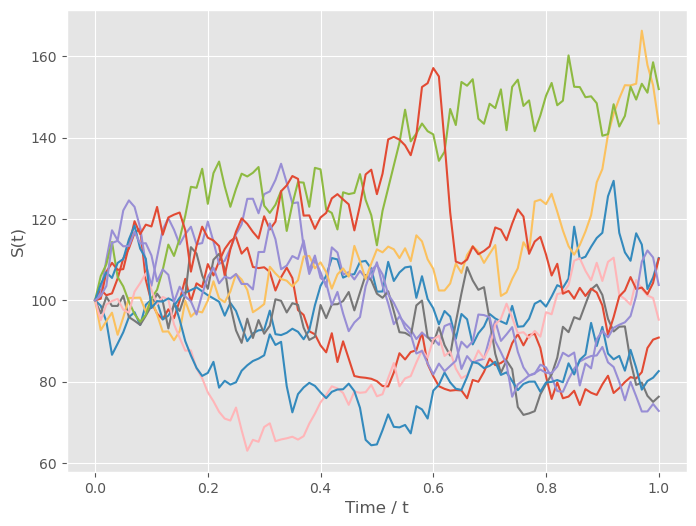

In [12]:
import matplotlib.pyplot as plt

#set x axis to time value)
dt = T/NumInterval
x_time = np.arange(0,T+dt*0.1,dt)

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.plot(x_time,(S[:, :10]))
plt.xlabel('Time / t')
plt.ylabel('S(t)')
plt.show()

To check if the desired result makes sense, we can also check the distribution of the final values

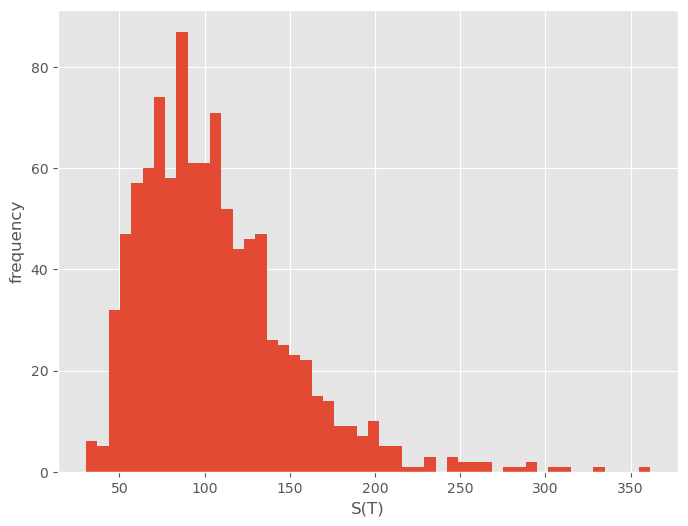

In [13]:
plt.figure(figsize=(8,6))
plt.hist(S[-1], bins=50)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()


We see that the distribution is log normal, albeit a bit chunky due to the number of sample points. We can run it agian, with more points to check if this resolves.

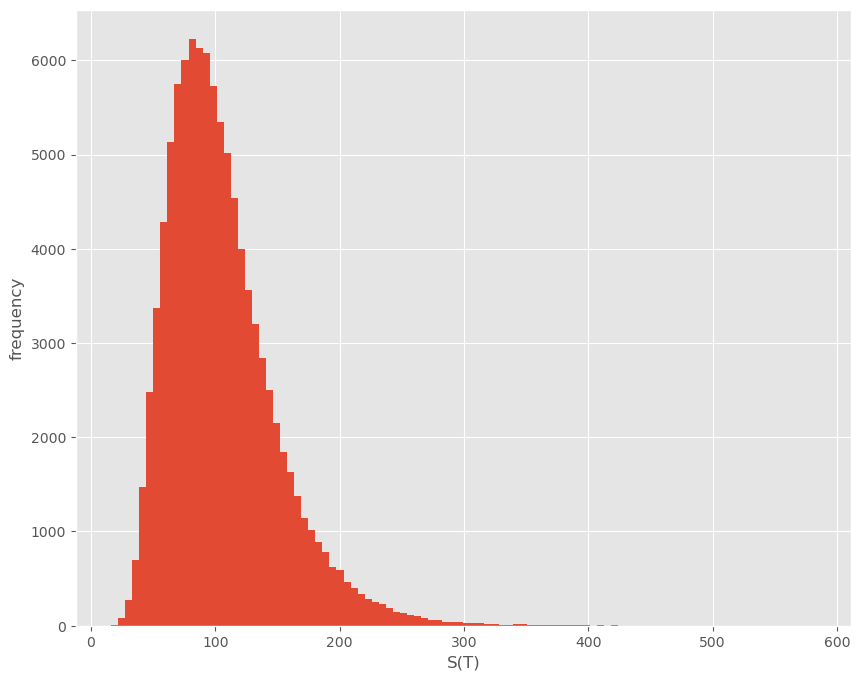

In [14]:
NumTrial = 100000
S = MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0)

plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()


As expected, the distribution tends closer to the log normal

Next step is to map this stock value to the value of the option. Lets consider a call option with strike price $K$. 
The payoff is $$\
p(S_{T}) = \max \left( S_{T}-K,0\right)\,.
$$

We can directly calculate the value of the option at time t and expiry T, by calculating all of the paths as in the steps before, calculating the payoff, taking the mean payoff, and discounting it back. Illustrated below:

Note here we are assuming we discount at same rate as $\mu$ (i.e. $\mu =$ risk free rate)

In [17]:
def MonteCarloEuropeanCallOption(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff
    finalS = S[-1]
    finalS -= Strike
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))

In [18]:
t = 0
K = 90
NumTrial = 100000
S_t = S0
value = MonteCarloEuropeanCallOption(S_t, K, mu, sigma, T, t, NumInterval, NumTrial)
print('Value of Call Option is:', value)

Value of Call Option is: 22.950698970315706


Now we can directly compare this to Black Scholes model, to check if our methodology is correct!


The formula for the analytical solution of the Black-Scholes equation for an european call option is:
$$
C(S,t) = S\, N(d_{1}) - K\,e^{-r(T-t)}N(d_{2})\,,
$$
where:
$$
d_{1} = \frac{\ln(S/X) + \left(r + \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
$$
d_{2} = d1 - \sigma\sqrt{T-t}
$$
and where $N(x)$ is the cumulative normal distribution:
$$
N(x)= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x} \; e^{-t^{2}/2} dt,.
$$

We can quickly write a function to calculate these values below:

In [25]:
from scipy import stats
def BlackScholesCallValue(S_t,K,mu,sigma,T,t):
    
    d1 = (np.log(S_t/K)+(mu+((sigma**2)/2))*(T-t))
    d1 /=(sigma*np.sqrt((T-t)))
    
    d2 = d1-sigma*np.sqrt((T-t))
    
    return S_t*stats.norm.cdf(d1) - K*np.exp(-mu*(T-t))*stats.norm.cdf(d2)

Now we can directly compare the two

In [81]:
NumTrial = 1000000
value = MonteCarloEuropeanCallOption(S_t, K, mu, sigma, T, t, NumInterval, NumTrial)
print('Value of Call Option via Monte Carlo is:', value)

valueBS = BlackScholesCallValue(S_t, K, mu, sigma, T, t)
print('Value of Call Option via Black Scholes is:', valueBS)

Value of Call Option via Monte Carlo is: 22.99674496955534
Value of Call Option via Black Scholes is: 22.984789059492478


Here, we see the result is extremely similar, which we would expect given the equivalence of these two methods

In [260]:
x = np.zeros(250)
x2 = 1*x
t = np.linspace(0,1,250)
for i in range(250):
    value = MonteCarloEuropeanCallOption(S_t, K, mu, sigma, T,t[i], 100, 100000)
    value2 = BlackScholesCallValue(S_t, K, mu, sigma, T,t[i])
    x[i] = value
    x2[i] = value2

C:\Users\natpe\AppData\Local\Temp\ipykernel_8288\716577858.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 /=(sigma*np.sqrt((T-t)))


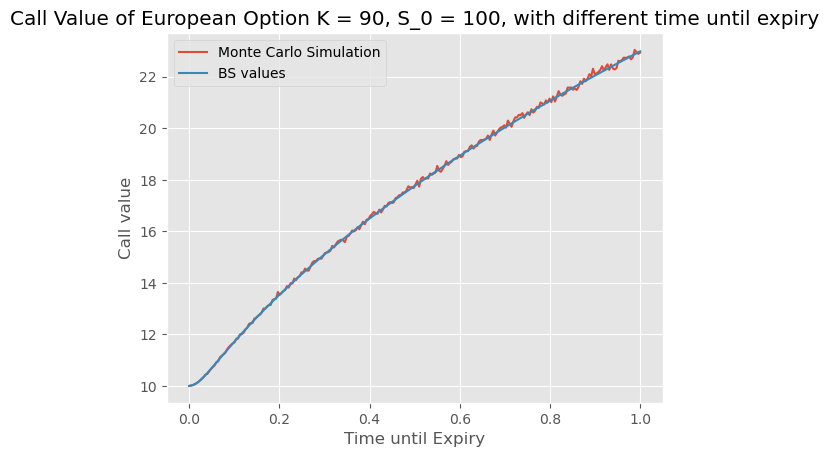

In [261]:
plt.plot(np.flip(t),x)
plt.plot(np.flip(t),x2)
plt.xlabel('Time until Expiry')
plt.title('Call Value of European Option K = 90, S_0 = 100, with different time until expiry')
plt.ylabel('Call value')
plt.legend(['Monte Carlo Simulation', 'BS values'])
plt.show()

# Exotic Options

Now that we have tested how to use Monte Carlo simulation to price a standard European option modelled by the Black Scholes model, we will now move on to move complicated option types, ones that we cannot analytically solve like in the BS model.

(For now we will continue to simulate the paths of the underlying price via the GBM model (later we will explore different models).

For different types of trivial options, we can directly look at the simulated path, and directly use this data to calculate average payoff, and price the option.

Let's start with a simple Asian option with a fixed strike price $K$, where 
$C(T) = max(A(0,T) - K,0)$, where $A$ is the average price over period $[0,T]$

Similarly to the european call option, we can immediately estimate the value of an option via the simulated Monte Carlo data'

Let's take the same underlying as the previous example to illustrate the difference

In [84]:
S = MonteCarloGBM(mu, sigma, T, NumInterval, NumTrial, S0)

In [87]:
def MonteCarloAsianCallOption_fixedstrike(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff

    #calculate average price
    finalS = np.mean(S,axis=0) - Strike
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))

In [91]:
P = MonteCarloAsianCallOption_fixedstrike(S_t, K, mu, sigma, T, t, NumInterval, NumTrial)
print('Estimate value of Asian Call Option:', P)

Estimate value of Asian Call Option: 15.618659391791747


Similarly, we can also the value of a floating strike Asian call option payout, with payoff
$C(T) = max(S(T)-A(T),0)$


In [92]:
def MonteCarloAsianCallOption_floatingstrike(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff

    #calculate average price
    finalS = S[-1] - np.mean(S,axis=0)
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))

In [93]:
P = MonteCarloAsianCallOption_floatingstrike(S_t, K, mu, sigma, T, t, NumInterval, NumTrial)
print('Estimate value of Asian Call Option:', P)

Estimate value of Asian Call Option: 10.335086281187934


And as expected, the price of an asian option is cheaper than the European counterpart, due to the averaging effect

Similarly, it is trivial estimate the value of other option types that simply require us to look at the paths, such as lookback option prices
i.e. For a fixed strike
$C(T) = max(A(T)-K,0)$, where $A(t) = max(S(t)), 0 \leq t \leq T$ 

and for a floating strike we have
$C(T) = max(S(T)-A(T),0)$, where $A(t) = min(S(t)), 0 \leq t \leq T$ 


In [268]:
def MonteCarloLookbackCallOption_fixedstrike(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff

    #calculate average price
    finalS = np.max(S,axis=0) - Strike
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))
def MonteCarloLookbackCallOption_floatingstrike(S_t, Strike, mu, sigma, T, t, NumInterval, NumTrial):
    #Monte Carlo Simulation of the paths
    S = MonteCarloGBM(mu, sigma, T-t, NumInterval, NumTrial, S_t)

    #calculate payoff

    #calculate average price
    finalS = S[-1] - np.min(S,axis=0)
    finalS[finalS<0] = 0
    
    return (np.mean(finalS)*np.e**(-mu*(T-t)))

In [269]:
x = np.zeros((250,5))
t = np.linspace(0,1,250)
for i in range(250):
    x[i,0] = MonteCarloEuropeanCallOption(S_t, K, mu, sigma, T,t[i], 100, 100000)
    x[i,1] = MonteCarloAsianCallOption_fixedstrike(S_t, K, mu, sigma, T,t[i], 100, 100000)
    x[i,2] = MonteCarloAsianCallOption_floatingstrike(S_t, K, mu, sigma, T,t[i], 100, 100000)
    x[i,3] = MonteCarloLookbackCallOption_fixedstrike(S_t, K, mu, sigma, T,t[i], 100, 100000)
    x[i,4] = MonteCarloLookbackCallOption_floatingstrike(S_t, K, mu, sigma, T,t[i], 100, 100000)

We can again plot what the price curves of the different option types look like

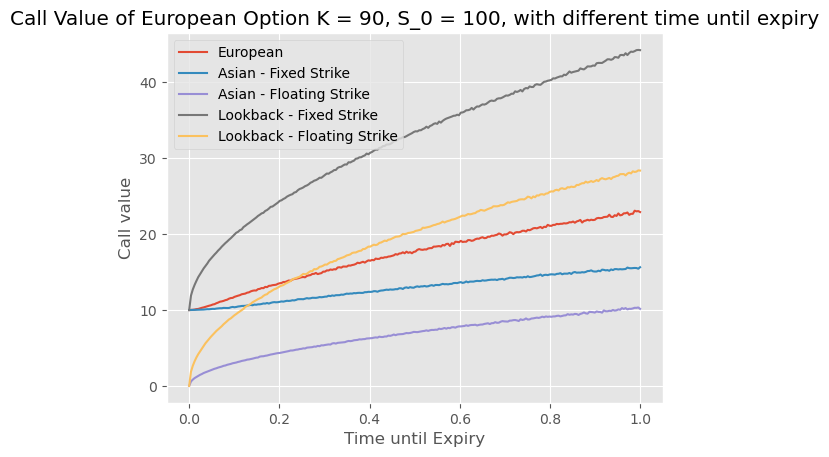

In [270]:
for i in range(5):
    plt.plot(np.flip(t),x[:,i])

plt.xlabel('Time until Expiry')
plt.title('Call Value of European Option K = 90, S_0 = 100, with different time until expiry')
plt.ylabel('Call value')
plt.legend(['European', 'Asian - Fixed Strike','Asian - Floating Strike', 'Lookback - Fixed Strike', 'Lookback - Floating Strike'])
plt.show()